In [95]:
import time
import pandas as pd
import numpy as np
import util
import pyBigWig
import seaborn as sns
import glob
source='data/source/'

tic=time.time()
def fix(rs):
    ratio=1
    gs=[]
    while len(gs)<len(rs):
        if len(gs)>0:
            rs=gs.copy()
        gs=[]
        skip=0
        for i in range(len(rs)-1):
            if skip==1:
                skip=0
                continue
            d0=rs[i][2]-rs[i][1]
            d1=rs[i+1][2]-rs[i+1][1]
            gap=rs[i+1][1]-rs[i][2]
            if rs[i][0]==rs[i+1][0] and d0>+ratio*gap and d1>ratio*gap:
                gs.append([rs[i][0],rs[i][1],rs[i+1][2]])
                skip=1
            else :
                gs.append([rs[i][0],rs[i][1],rs[i][2]])
        gs.append(rs[-1])
    print(len(gs))
    return pd.DataFrame(rs)
def get_cg(x):
    cg=set(range(x['b'],x['e']))
    cg=ind[x['ch']].intersection(cg)
    return cg
def hmr2df(hmr):
    gs=pd.read_table(hmr,header=None,usecols=[0,1,2])
    #gs=gs[gs[0]=='chr1']
    gs=gs[~gs[0].isin(['chrX','chrY','chrM'])]
    print(len(gs),end=',')
    #gs=fix(gs.values)
    gs.columns=['ch','b','e']   
    gs['d']=gs['e']-gs['b']
    gs['r']=gs.apply(lambda x:get_cg(x) ,axis=1)
    gs['rd']=gs.r.apply(lambda x:len(x))
    gg=gs.groupby('ch')['r'].apply(list)
    gg=gg.apply(lambda x:set.union(*x))    
    return (gs,gg)   

In [91]:
ind=pd.read_table('data/meth/h/Human_H1.meth',engine='c',usecols=[0,1],header=None)
ind=ind.groupby(0)[1].apply(list)
ind=ind.apply(lambda x:set(x))

In [81]:
samples=['s','t','h']
c={}
cg={}
cu={}
cug={}

In [96]:
for s in samples:
    c[s],cg[s]=hmr2df('data/meth/'+s+'/'+s+'.hmr')

95351,52648,39517,

In [97]:
c['t']['s']=c['t'].apply(lambda x:len(cg['s'][x['ch']].intersection(x['r'])),1)
c['s']['t']=c['s'].apply(lambda x:len(cg['t'][x['ch']].intersection(x['r'])),1)

In [98]:
for s in ['t','s']:
    path='data/meth/'+s+'/'+s+'.bw'
    bw=pyBigWig.open(path)
    c[s]['cg']=c[s].apply(lambda x: np.count_nonzero(~np.isnan(bw.values(x['ch'],x['b'],x['e']))),axis=1)

In [154]:
c['t']['rd'].sum()/10**6

2.609167

In [155]:
c['t'].s.sum()/10**6

2.352314

In [156]:
c['s']['rd'].sum()/10**6

3.485922

In [157]:
c['s'].t.sum()/10**6

2.352314

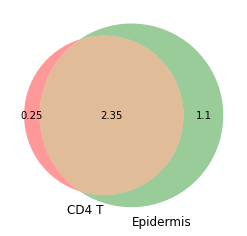

In [118]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Use the venn2 function
venn2(subsets = (2.6-2.35,3.5-2.4,2.35), set_labels = ('CD4 T', 'Epidermis'))
plt.show()

In [121]:
for s in ['s','t']:
    for n in ['y','o']:
        path='data/meth/'+s+'/'+n+'.bw'
        bw=pyBigWig.open(path)
        c[s][n]=c[s].apply(lambda x: bw.stats(x['ch'],x['b'],x['e'],'mean',exact=True)[0],axis=1)
    c[s]['dd']=c[s]['o']-c[s]['y']
    cu[s]=c[s][c[s]['dd']>.1]
    cug[s]=cu[s].groupby('ch')['r'].apply(list)
    cug[s]=cug[s].apply(lambda x:set.union(*x))                   

In [125]:
for s1 in ['s','t']:
    for s2 in ['s','t']:
        if s1!=s2:
            cu[s1][s2+'u']=cu[s1].apply(lambda x:len(cug[s2][x['ch']].intersection(x['r'])),1)

/local/scratch/moqri/slrmtmp.30871986/ipykernel_10549/2179739204.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cu[s1][s2+'u']=cu[s1].apply(lambda x:len(cug[s2][x['ch']].intersection(x['r'])),1)


In [222]:
t=cu['t']
t.su.sum()/10**3

26.951

In [223]:
t.rd.sum()/10**3

259.444

In [227]:
t[t.su>0].h.sum()/10**3

22.833

In [228]:
t=cu['s']
t.tu.sum()/10**3

26.951

In [229]:
t.rd.sum()/10**3

94.765

In [230]:
t[t.tu>0].h.sum()/10**3

17.162

In [60]:
bw='data/source/ENCFF109KCQ.bigWig'
bw=pyBigWig.open(bw)
bs=[]
for i,r in ts.iterrows():
    bs.append(bw.stats(r['ch'],int(r['b']),int(r['e']),'max')[0])
ts['ez']=bs    

<AxesSubplot:xlabel='h', ylabel='ez'>

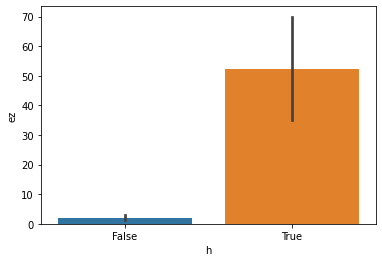

In [61]:
sns.barplot(data=ts[['h','ez']],x='h',y='ez')

In [62]:
tss=pd.read_csv('data/tss.csv',index_col=0)
exp=pd.read_csv('data/exp.csv',index_col=0)

In [63]:
exp['ch']='chr'+exp['chrom'].astype(str)
expg=exp.groupby('ch')['ts'].apply(list)

In [64]:
h=c['h'].copy()

In [65]:
len(h)

39517

In [66]:
#h,hg=hmr2df('data/meth/h/h.hmr')

In [67]:
bw='data/source/ENCFF109KCQ.bigWig'
bw=pyBigWig.open(bw)
bs=[]
for i,r in h.iterrows():
    bs.append(bw.stats(r['ch'],int(r['b']),int(r['e']),'max')[0])
h['ez']=bs

In [68]:
for s in ['s','f','t']:
    for n in ['y','o']:
        path='data/meth/'+s+'/'+n+'.bw'
        bw=pyBigWig.open(path)
        h[s+n]=h.apply(lambda x: bw.stats(x['ch'],x['b'],x['e'],'mean',exact=True)[0],axis=1)
    h[s+'d']=h[s+'o']-h[s+'y']

<AxesSubplot:>

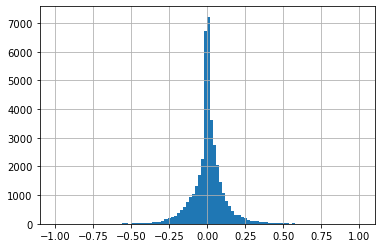

In [ ]:
h['td'].hist(bins=100)

In [74]:
hz=h[h.ez>100].copy()
len(hz)

1184

In [79]:
len(hz[hz.td<0])

67

In [58]:
def get_ts(rang,chrom):
    com=rang.intersection(expg[chrom])
    if len(com)>0:
        ts=list(com)[0]
        ts=exp.loc[(exp.chrom==int(chrom[3:])) & (exp.ts==ts)].index.values[0]
    else:
        ts=np.nan
    return(ts)

In [64]:
hz['ts']=hz.apply(lambda x: get_ts(x['r'],x['ch']),axis=1)

In [65]:
hzt=hz[hz.ts.notna()]
len(hzt)

1465

In [66]:
len(hzt[hzt.td<0])

76